# Load Data

In [1]:
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import io
import requests
import PIL
import tarfile

import torchvision.transforms.functional as TF
%pip install DALL-E
from dall_e import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.models as models
import time, os, copy, numpy as np
import sys

import attr
import math

import torch.nn.functional as F

torch.manual_seed(17)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions

In [3]:
logit_laplace_eps: float = 0.1

@attr.s(eq=False)
class Conv2d(nn.Module):
	n_in:  int = attr.ib(validator=lambda i, a, x: x >= 1)
	n_out: int = attr.ib(validator=lambda i, a, x: x >= 1)
	kw:    int = attr.ib(validator=lambda i, a, x: x >= 1 and x % 2 == 1)

	use_float16:   bool         = attr.ib(default=True)
	device:        torch.device = attr.ib(default=torch.device('cpu'))
	requires_grad: bool         = attr.ib(default=False)

	def __attrs_post_init__(self) -> None:
		super().__init__()

		w = torch.empty((self.n_out, self.n_in, self.kw, self.kw), dtype=torch.float32,
			device=self.device, requires_grad=self.requires_grad)
		w.normal_(std=1 / math.sqrt(self.n_in * self.kw ** 2))

		b = torch.zeros((self.n_out,), dtype=torch.float32, device=self.device,
			requires_grad=self.requires_grad)
		self.w, self.b = nn.Parameter(w), nn.Parameter(b)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		if self.use_float16 and 'cuda' in self.w.device.type:
			if x.dtype != torch.float16:
				x = x.half()

			w, b = self.w.half(), self.b.half()
		else:
			if x.dtype != torch.float32:
				x = x.float()

			w, b = self.w, self.b

		return F.conv2d(x, w, b, padding=(self.kw - 1) // 2)

def map_pixels(x: torch.Tensor) -> torch.Tensor:
    if len(x.shape) != 4:
      raise ValueError('expected input to be 4d')
    if x.dtype != torch.float:
      raise ValueError('expected input to have type float')

    return (1 - 2 * logit_laplace_eps) * x + logit_laplace_eps

def unmap_pixels(x: torch.Tensor) -> torch.Tensor:
    if len(x.shape) != 4:
      raise ValueError('expected input to be 4d')
    if x.dtype != torch.float:
      raise ValueError('expected input to have type float')

    return torch.clamp((x - logit_laplace_eps) / (1 - 2 * logit_laplace_eps), 0, 1)
 
target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(transforms.ToTensor()(img), 0)
    return map_pixels(img)

## Encoder

In [4]:
import attr
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections  import OrderedDict
from functools    import partial
from dall_e.utils import Conv2d

@attr.s(eq=False, repr=False)
class EncoderBlock(nn.Module):
	n_in:     int = attr.ib(validator=lambda i, a, x: x >= 1)
	n_out:    int = attr.ib(validator=lambda i, a, x: x >= 1 and x % 4 ==0)
	n_layers: int = attr.ib(validator=lambda i, a, x: x >= 1)

	device:        torch.device = attr.ib(default=None)
	requires_grad: bool         = attr.ib(default=False)

	def __attrs_post_init__(self) -> None:
		super().__init__()
		self.n_hid = self.n_out // 4
		self.post_gain = 1 / (self.n_layers ** 2)

		make_conv     = partial(Conv2d, device=self.device, requires_grad=self.requires_grad)
		self.id_path  = make_conv(self.n_in, self.n_out, 1) if self.n_in != self.n_out else nn.Identity()
		self.res_path = nn.Sequential(OrderedDict([
				('relu_1', nn.ReLU()),
				('conv_1', make_conv(self.n_in,  self.n_hid, 3)),
				('relu_2', nn.ReLU()),
				('conv_2', make_conv(self.n_hid, self.n_hid, 3)),
				('relu_3', nn.ReLU()),
				('conv_3', make_conv(self.n_hid, self.n_hid, 3)),
				('relu_4', nn.ReLU()),
				('conv_4', make_conv(self.n_hid, self.n_out, 1)),]))

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.id_path(x) + self.post_gain * self.res_path(x)

@attr.s(eq=False, repr=False)
class Encoder(nn.Module):
	group_count:     int = 4
	n_hid:           int = attr.ib(default=256,  validator=lambda i, a, x: x >= 64)
	n_blk_per_group: int = attr.ib(default=2,    validator=lambda i, a, x: x >= 1)
	input_channels:  int = attr.ib(default=3,    validator=lambda i, a, x: x >= 1)
	vocab_size:      int = attr.ib(default=8192, validator=lambda i, a, x: x >= 512)

	device:              torch.device = attr.ib(default=torch.device('cpu'))
	requires_grad:       bool         = attr.ib(default=False)
	use_mixed_precision: bool         = attr.ib(default=True)

	def __attrs_post_init__(self) -> None:
		super().__init__()

		blk_range  = range(self.n_blk_per_group)
		n_layers   = self.group_count * self.n_blk_per_group
		make_conv  = partial(Conv2d, device=self.device, requires_grad=self.requires_grad)
		make_blk   = partial(EncoderBlock, n_layers=n_layers, device=self.device,
				requires_grad=self.requires_grad)

		self.blocks = nn.Sequential(OrderedDict([
			('input', make_conv(self.input_channels, 1 * self.n_hid, 7)),
			('group_1', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(1 * self.n_hid, 1 * self.n_hid)) for i in blk_range],
				('pool', nn.MaxPool2d(kernel_size=2)),
			]))),
			('group_2', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(1 * self.n_hid if i == 0 else 2 * self.n_hid, 2 * self.n_hid)) for i in blk_range],
				('pool', nn.MaxPool2d(kernel_size=2)),
			]))),
			('group_3', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(2 * self.n_hid if i == 0 else 4 * self.n_hid, 4 * self.n_hid)) for i in blk_range],
				('pool', nn.MaxPool2d(kernel_size=2)),
			]))),
			('group_4', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(4 * self.n_hid if i == 0 else 8 * self.n_hid, 8 * self.n_hid)) for i in blk_range],
			]))),
			('output', nn.Sequential(OrderedDict([
				('relu', nn.ReLU()),
				('conv', make_conv(8 * self.n_hid, self.vocab_size, 1, use_float16=False)),
			]))),
		]))

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		if len(x.shape) != 4:
			raise ValueError(f'input shape {x.shape} is not 4d')
		if x.shape[1] != self.input_channels:
			raise ValueError(f'input has {x.shape[1]} channels but model built for {self.input_channels}')
		if x.dtype != torch.float32:
			raise ValueError('input must have dtype torch.float32')

		return self.blocks(x)

## Decoder

In [5]:

@attr.s(eq=False, repr=False)
class DecoderBlock(nn.Module):
	n_in:     int = attr.ib(validator=lambda i, a, x: x >= 1)
	n_out:    int = attr.ib(validator=lambda i, a, x: x >= 1 and x % 4 ==0)
	n_layers: int = attr.ib(validator=lambda i, a, x: x >= 1)

	device:        torch.device = attr.ib(default=None)
	requires_grad: bool         = attr.ib(default=False)

	def __attrs_post_init__(self) -> None:
		super().__init__()
		self.n_hid = self.n_out // 4
		self.post_gain = 1 / (self.n_layers ** 2)

		make_conv     = partial(Conv2d, device=self.device, requires_grad=self.requires_grad)
		self.id_path  = make_conv(self.n_in, self.n_out, 1) if self.n_in != self.n_out else nn.Identity()
		self.res_path = nn.Sequential(OrderedDict([
				('relu_1', nn.ReLU()),
				('conv_1', make_conv(self.n_in,  self.n_hid, 1)),
				('relu_2', nn.ReLU()),
				('conv_2', make_conv(self.n_hid, self.n_hid, 3)),
				('relu_3', nn.ReLU()),
				('conv_3', make_conv(self.n_hid, self.n_hid, 3)),
				('relu_4', nn.ReLU()),
				('conv_4', make_conv(self.n_hid, self.n_out, 3)),]))

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.id_path(x) + self.post_gain * self.res_path(x)

@attr.s(eq=False, repr=False)
class Decoder(nn.Module):
	group_count:     int = 4
	n_init:          int = attr.ib(default=128,  validator=lambda i, a, x: x >= 8)
	n_hid:           int = attr.ib(default=256,  validator=lambda i, a, x: x >= 64)
	n_blk_per_group: int = attr.ib(default=2,    validator=lambda i, a, x: x >= 1)
	output_channels: int = attr.ib(default=3,    validator=lambda i, a, x: x >= 1)
	vocab_size:      int = attr.ib(default=8192, validator=lambda i, a, x: x >= 512)

	device:              torch.device = attr.ib(default=torch.device('cpu'))
	requires_grad:       bool         = attr.ib(default=False)
	use_mixed_precision: bool         = attr.ib(default=True)

	def __attrs_post_init__(self) -> None:
		super().__init__()

		blk_range  = range(self.n_blk_per_group)
		n_layers   = self.group_count * self.n_blk_per_group
		make_conv  = partial(Conv2d, device=self.device, requires_grad=self.requires_grad)
		make_blk   = partial(DecoderBlock, n_layers=n_layers, device=self.device,
				requires_grad=self.requires_grad)

		self.blocks = nn.Sequential(OrderedDict([
			('input', make_conv(self.vocab_size, self.n_init, 1, use_float16=False)),
			('group_1', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(self.n_init if i == 0 else 8 * self.n_hid, 8 * self.n_hid)) for i in blk_range],
				('upsample', nn.Upsample(scale_factor=2, mode='nearest')),
			]))),
			('group_2', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(8 * self.n_hid if i == 0 else 4 * self.n_hid, 4 * self.n_hid)) for i in blk_range],
				('upsample', nn.Upsample(scale_factor=2, mode='nearest')),
			]))),
			('group_3', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(4 * self.n_hid if i == 0 else 2 * self.n_hid, 2 * self.n_hid)) for i in blk_range],
				('upsample', nn.Upsample(scale_factor=2, mode='nearest')),
			]))),
			('group_4', nn.Sequential(OrderedDict([
				*[(f'block_{i + 1}', make_blk(2 * self.n_hid if i == 0 else 1 * self.n_hid, 1 * self.n_hid)) for i in blk_range],
			]))),
			('output', nn.Sequential(OrderedDict([
				('relu', nn.ReLU()),
				('conv', make_conv(1 * self.n_hid, 2 * self.output_channels, 1)),
			]))),
		]))

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		if len(x.shape) != 4:
			raise ValueError(f'input shape {x.shape} is not 4d')
		if x.shape[1] != self.vocab_size:
			raise ValueError(f'input has {x.shape[1]} channels but model built for {self.vocab_size}')
		if x.dtype != torch.float32:
			raise ValueError('input must have dtype torch.float32')

		return self.blocks(x)

## Training Loop

In [6]:
class DVAE(nn.Module):
    def __init__(self):
        super(DVAE, self).__init__()
        #dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
        #self.dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)
        self.enc = Encoder()
        self.dec = Decoder()

    def encode(self, x):
        return self.enc(x)

    def reparameterize(self, z_logits):
        z = torch.argmax(z_logits, axis=1)
        z = F.one_hot(z, num_classes=self.enc.vocab_size).permute(0, 3, 1, 2).float()
        return z

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        z_logits = self.encode(x)
        z = self.reparameterize(z_logits)
        output = self.decode(z).float()
        return torch.sigmoid(output[:, :3]), output[:, 3:]
        
def loss_function3(x_rec, x):
    loss = nn.BCELoss(reduction='mean')
    BCE = loss(x_rec, x)
    KLD_LOSS = nn.KLDivLoss(reduction='mean', log_target=True)
    KLD = KLD_LOSS(x_rec, x)

    return BCE + KLD

def train(model, optimizer, scheduler, epoch):
    optimizer.step()
    scheduler.step()
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        #recon_batch = model.encode(data)

        recon_batch, _ = model(data)
        loss = loss_function3(recon_batch, data)
        #loss = loss_function3(data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % 40 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

# Test 3

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


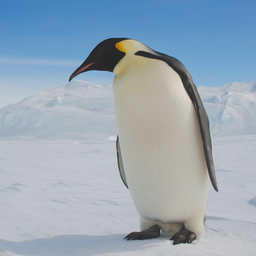

In [7]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(transforms.ToPILImage(mode='RGB')(x[0]))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DVAE().to(device)
#optimizer = optim.Adam(model.parameters(), lr=0.005)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.95)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
train_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
train_data_dir = '../content/drive/MyDrive/tiny-imagenet-200/test' # personal dataset, change it if necessary
train_datasets = datasets.ImageFolder(train_data_dir, train_transforms)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=10, shuffle=True, num_workers=4)

x = x.to(device)

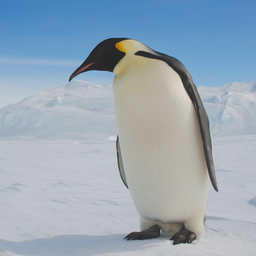

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train Epoch: 1 [0/10000 (0%)]	Loss: 0.074507
Train Epoch: 1 [10/10000 (0%)]	Loss: 0.062513
Train Epoch: 1 [20/10000 (0%)]	Loss: 0.077840
Train Epoch: 1 [30/10000 (0%)]	Loss: 0.071364
Train Epoch: 1 [40/10000 (0%)]	Loss: 0.071124
Train Epoch: 1 [50/10000 (0%)]	Loss: 0.076333
Train Epoch: 1 [60/10000 (1%)]	Loss: 0.072743
Train Epoch: 1 [70/10000 (1%)]	Loss: 0.082858
Train Epoch: 1 [80/10000 (1%)]	Loss: 0.061862
Train Epoch: 1 [90/10000 (1%)]	Loss: 0.058383
Train Epoch: 1 [100/10000 (1%)]	Loss: 0.076215
Train Epoch: 1 [110/10000 (1%)]	Loss: 0.057265
Train Epoch: 1 [120/10000 (1%)]	Loss: 0.062993
Train Epoch: 1 [130/10000 (1%)]	Loss: 0.072674
Train Epoch: 1 [140/10000 (1%)]	Loss: 0.058667
Train Epoch: 1 [150/10000 (2%)]	Loss: 0.065755
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.060798
Train Epoch: 1 [170/10000 (2%)]	Loss: 0.062211
Train Epoch: 1 [180/10000 (2%)]	Loss: 0.059356
Train Epoch: 1 [190/10000 (2%)]	Loss: 0.056687
Train Epoch: 1 [200/10000 (2%)]	Loss: 0.058589
Train Epoch: 1 [210/1000

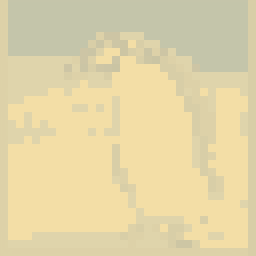

Train Epoch: 2 [0/10000 (0%)]	Loss: 0.052927
Train Epoch: 2 [10/10000 (0%)]	Loss: 0.051663
Train Epoch: 2 [20/10000 (0%)]	Loss: 0.052086
Train Epoch: 2 [30/10000 (0%)]	Loss: 0.058142
Train Epoch: 2 [40/10000 (0%)]	Loss: 0.052635
Train Epoch: 2 [50/10000 (0%)]	Loss: 0.054288
Train Epoch: 2 [60/10000 (1%)]	Loss: 0.049770
Train Epoch: 2 [70/10000 (1%)]	Loss: 0.057490
Train Epoch: 2 [80/10000 (1%)]	Loss: 0.057594
Train Epoch: 2 [90/10000 (1%)]	Loss: 0.053521
Train Epoch: 2 [100/10000 (1%)]	Loss: 0.056561
Train Epoch: 2 [110/10000 (1%)]	Loss: 0.054579
Train Epoch: 2 [120/10000 (1%)]	Loss: 0.056711
Train Epoch: 2 [130/10000 (1%)]	Loss: 0.054259
Train Epoch: 2 [140/10000 (1%)]	Loss: 0.053533
Train Epoch: 2 [150/10000 (2%)]	Loss: 0.052880
Train Epoch: 2 [160/10000 (2%)]	Loss: 0.053313
Train Epoch: 2 [170/10000 (2%)]	Loss: 0.054821
Train Epoch: 2 [180/10000 (2%)]	Loss: 0.054004
Train Epoch: 2 [190/10000 (2%)]	Loss: 0.061636
Train Epoch: 2 [200/10000 (2%)]	Loss: 0.051801
Train Epoch: 2 [210/1000

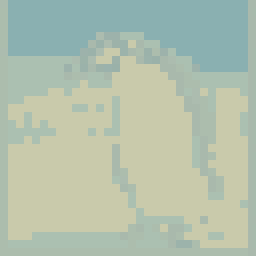

Train Epoch: 3 [0/10000 (0%)]	Loss: 0.058872
Train Epoch: 3 [10/10000 (0%)]	Loss: 0.051067
Train Epoch: 3 [20/10000 (0%)]	Loss: 0.048415
Train Epoch: 3 [30/10000 (0%)]	Loss: 0.051963
Train Epoch: 3 [40/10000 (0%)]	Loss: 0.053789
Train Epoch: 3 [50/10000 (0%)]	Loss: 0.051473
Train Epoch: 3 [60/10000 (1%)]	Loss: 0.052196
Train Epoch: 3 [70/10000 (1%)]	Loss: 0.051343
Train Epoch: 3 [80/10000 (1%)]	Loss: 0.047789
Train Epoch: 3 [90/10000 (1%)]	Loss: 0.050721
Train Epoch: 3 [100/10000 (1%)]	Loss: 0.057375
Train Epoch: 3 [110/10000 (1%)]	Loss: 0.051594
Train Epoch: 3 [120/10000 (1%)]	Loss: 0.049955
Train Epoch: 3 [130/10000 (1%)]	Loss: 0.060136
Train Epoch: 3 [140/10000 (1%)]	Loss: 0.051745
Train Epoch: 3 [150/10000 (2%)]	Loss: 0.050226
Train Epoch: 3 [160/10000 (2%)]	Loss: 0.050552
Train Epoch: 3 [170/10000 (2%)]	Loss: 0.054889
Train Epoch: 3 [180/10000 (2%)]	Loss: 0.049206
Train Epoch: 3 [190/10000 (2%)]	Loss: 0.050246
Train Epoch: 3 [200/10000 (2%)]	Loss: 0.049600
Train Epoch: 3 [210/1000

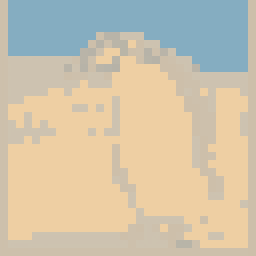

Train Epoch: 4 [0/10000 (0%)]	Loss: 0.052308
Train Epoch: 4 [10/10000 (0%)]	Loss: 0.050689
Train Epoch: 4 [20/10000 (0%)]	Loss: 0.052834
Train Epoch: 4 [30/10000 (0%)]	Loss: 0.054598
Train Epoch: 4 [40/10000 (0%)]	Loss: 0.050258
Train Epoch: 4 [50/10000 (0%)]	Loss: 0.048587
Train Epoch: 4 [60/10000 (1%)]	Loss: 0.059796
Train Epoch: 4 [70/10000 (1%)]	Loss: 0.055640
Train Epoch: 4 [80/10000 (1%)]	Loss: 0.048620
Train Epoch: 4 [90/10000 (1%)]	Loss: 0.055680
Train Epoch: 4 [100/10000 (1%)]	Loss: 0.050856
Train Epoch: 4 [110/10000 (1%)]	Loss: 0.050609
Train Epoch: 4 [120/10000 (1%)]	Loss: 0.051089
Train Epoch: 4 [130/10000 (1%)]	Loss: 0.047057
Train Epoch: 4 [140/10000 (1%)]	Loss: 0.059353
Train Epoch: 4 [150/10000 (2%)]	Loss: 0.048720
Train Epoch: 4 [160/10000 (2%)]	Loss: 0.050003
Train Epoch: 4 [170/10000 (2%)]	Loss: 0.052935
Train Epoch: 4 [180/10000 (2%)]	Loss: 0.050981
Train Epoch: 4 [190/10000 (2%)]	Loss: 0.051714
Train Epoch: 4 [200/10000 (2%)]	Loss: 0.052912
Train Epoch: 4 [210/1000

KeyboardInterrupt: ignored

In [10]:
display(transforms.ToPILImage(mode='RGB')(x[0]))
for epoch in range(1,  6):
    train(model, optimizer, exp_lr_scheduler, epoch)
    
    z_logits = model.encode(x)
    z = torch.argmax(z_logits, axis=1)
    z = F.one_hot(z, num_classes=8192).permute(0, 3, 1, 2).float()

    x_stats = model.decode(z).float()
    x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
    x_rec = transforms.ToPILImage(mode='RGB')(x_rec[0])

    display_markdown('Reconstructed image:')
    display(x_rec)
    #test(epoch)
    #with torch.no_grad():
    #    sample = torch.randn(1, 3, 256, 256).to(device)
    #    sample = decoder3(encoder3(sample))
        #save_image(sample.view(64, 1, 28, 28), '/results/sample_' + str(epoch) + '.png')

torch.Size([1, 3, 256, 256])


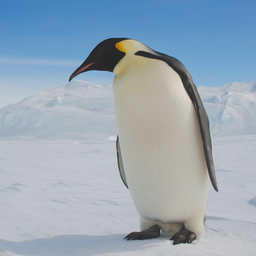

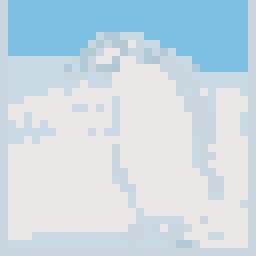

In [14]:
z_logits = model.encode(x)
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=8192).permute(0, 3, 1, 2).float()

x_stats = model.decode(z).float()

x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
print(x_stats[:,:3].shape)
x_rec = transforms.ToPILImage(mode='RGB')(x_rec[0])

display(transforms.ToPILImage(mode='RGB')(x[0]))

display_markdown('Reconstructed image:')
display(x_rec)